# Particle filter on a road network

Let us do a simple road network with 6 intersections where each road is two-way

```
4-------5-------6
|       |       |
|       |       |
|       |       |
1-------2-------3
```

There are really 14 directed edges:
$$
e_i \in \{(1,2),(1,4),(2,1),(2,3),(2,5),(3,2),(3,6),(4,1),(4,5),(5,4),(6,3),(6,5)\}
$$

Each edge shall also have a length associated with it. For simplicity, we shall make each edge of length 100m. A vehicle travelling along an edge shall have a position and velocity associated with it. 

In [1]:
from __future__ import division

%matplotlib notebook
#%matplotlib inline
import time
import random
import numpy as np
from scipy.stats import norm
import scipy.io as sio
import matplotlib as mpl
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections as mc
from scipy.stats import multivariate_normal as mvn
from math import atan2
from tqdm import tqdm_notebook as tqdm
import copy
import datetime

from IPython.display import display, Markdown, Latex

In [2]:
class Roadmap:
    """A class to represent a road network"""
    
    def __init__(self, nodes, edges, bidirectional=True):
        """
        nodes: list of tuples (x, y). Defines the cartesian location of each intersection.
        edges: list of tuples (start, end). Defines the roads between intersections. Each edge is 
            unidirectional.
        """
        self.graph = {node : {} for node in nodes}
        for edge in edges:
            a = nodes[edge[0]]
            b = nodes[edge[1]]
            dist = np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
            self.graph[a][b] = dist
            if bidirectional:
                self.graph[b][a] = dist
                
        self._total_len = 0.0
        for dests in self.graph.values():
            self._total_len += np.sum(list(dests.values()))
               
    def get_nearest_waypoint(self, pos):
        waypoint = None
        min_dist = 999999999
        for node in self.graph:
            dist = (pos[0] - node[0])**2 + (pos[1] - node[1])**2
            if dist < min_dist:
                min_dist = dist
                waypoint = node
        return waypoint

    def get_next_waypoint(self, waypoint, psi):
        options = self.graph[waypoint].keys()
        next_wp = random.choice(options)
        next_psi = atan2(next_wp[0] - waypoint[0], next_wp[1] - waypoint[1])
        diff_angle = abs(((next_psi - psi) + np.pi) % (2*np.pi) - np.pi)
        return next_wp

    def get_loc(self, state):
        """Returns the (x,y) location of a position along an edge
        
        edge -- tuple containing the (x,y) coordnates of 
                the beginning and ending nodes of the edge
        pos  -- value between 0 and 1 indicating the distance along the edge
        """
        
        edge = state[0]
        pos = state[1]
        
        try:
            self.graph[edge[0]][edge[1]]
        except KeyError:
            raise ValueError("Invalid roadmap edge.")
            
        loc = (pos*edge[1][0] + (1-pos)*edge[0][0],
               pos*edge[1][1] + (1-pos)*edge[0][1])
        return loc
#         raise NotImplementedError
    
    @property
    def total_length(self):
        return self._total_len
    
    def visualize(self, ax):
        edges = []
        for a in self.graph:
            edges += [(a, b) for b in self.graph[a]]
        lc = mc.LineCollection(edges, colors=[(0,0,0,1)])
        ax.add_collection(lc)
        

In [3]:
class Particle(object):
    def __init__(self, roadmap, v0, dt, e0=None, x0=None, sigma=0.1):
        """A Particle contains the state and dynamic model of one hypothesis of a vehicle location.
        
        The particle's state consists of which road segment the vehicle is on and how far along 
        that road segment the vehicle is, on a scale of 0 to 1. The particle also stores its 
        nominal velocity and noise characteristics.
        
        roadmap -- object containing a graph describing the network of roads
        
        """
        # current edge
        self._roadmap = roadmap
        if e0 is None:
            a = random.choice(list(self._roadmap.graph.keys()))
            b = random.choice(list(self._roadmap.graph[a].keys()))
            self._e = (a, b)
        else:
            self._e = e0
        self._e_len = self._roadmap.graph[self._e[0]][self._e[1]]
        # current position on edge 
        if x0 is None:
            self._x = random.random()
        else:
            self._x = x0
        self._v = v0
        self._sigma = sigma
        self._dt = dt
        self.split = 0
        
    def predict(self):
        """Propogate the particle's state based on its dynamics and the roadmap
        
        When a particle is updated, it moves along the road segment by v0*dt, normalized by the 
        length of its current road. If it reaches the end of the road (x >= 1), it queries the
        roadmap for other roads that connect to the current intersection and chooses one at
        random.
        """
        n = 0#np.random.normal(scale=self._sigma)
        self._x += (self._v + n)*self._dt/self._e_len
        self.split = 0
        
        if self._x >= 1.:
            dest_list = list(self._roadmap.graph[self._e[1]].keys())
            # no U-turns
            dest_list.remove(self._e[0])
            self.split = len(dest_list)
            self._e = (self._e[1], random.choice(dest_list))
            self._e_len = self._roadmap.graph[self._e[0]][self._e[1]]
            self._x -= 1
            
        return self.state
        
    @property
    def state(self):
        return (self._e, self._x)
    
    @state.setter
    def state(self, new_state):
        e = new_state[0]
        x = new_state[1]
        try:
            self._roadmap.graph[e[0]][e[1]]
            self._e = e
        except KeyError:
            raise ValueError("Invalid roadmap edge.")
        if x < 0.:
            self._x = 0.
        elif x > 1.:
            self._x = 1.
        else:
            self._x = x
        
    @property
    def loc(self):
        return self._roadmap.get_loc(self.state)

In [4]:
# vectorized particle filter
class PF(object):
    def __init__(self, roadmap, num_particles, dt, v0=10., sigma=4, x0=None, P_fa=0.1, P_miss=0.05):
        self._roadmap = roadmap
        self._N = num_particles
        self._v0 = v0
        # particle shape
        ## x, y, speed, start_x, start_y, end_x, end_y, direction_x, direction_y, distance, sigma, w
        self.X = np.ndarray(shape=(self._N, 12))
        
        if x0 is None:
            #uniformly distribute the particles on the roadway
            for i in range(self._N):
                a = random.choice(list(self._roadmap.graph.keys()))
                b = np.array(random.choice(list(self._roadmap.graph[a].keys())))
                a = np.array(a)
                vector = b - a
                loc = a + vector * random.random()
                distance = np.linalg.norm(vector)
                vector = vector/distance
                self.X[i] = [loc[0], loc[1], v0, a[0], a[1], b[0],
                                      b[1], vector[0], vector[1], distance, sigma, 1/self._N]

        else:
            raise NotImplementedError

        self.best = self.X[0]
        self._dt = dt
        self._P_fa = P_fa
        self._P_miss = P_miss
    
    def get_particle_distance_from_target(self, loc, acceptable_distance):
        avg = 0
        num_in_distance = 0
        dist = np.linalg.norm(self.X[:,0:2] - loc, axis=1)
        num_in_distance = len(np.where(dist < acceptable_distance)[0])
        avg = np.average(dist)
        return avg, num_in_distance

    def get_max_particle_density(self):
        overall_avg = 0
        min_avg = 9999999999
        for i in range(len(self.X)):
            dist = np.linalg.norm(self.X[:,0:2] - self.X[i,0:2], axis=1)
            avg_dist = np.average(dist)
            overall_avg += avg_dist
            if avg_dist < min_avg:
                min_avg = avg_dist
        return overall_avg, min_avg

    def get_edge_particle_density(self):
        edges = {}
        edges_present, count = np.unique(self.X[:, 3:7], return_counts=True, axis=0)
        for i in range(len(edges_present)):
            start_edge = (edges_present[i][0], edges_present[i][1])
            end_edge = (edges_present[i][2], edges_present[i][3])
            edges[(start_edge, end_edge)] = count[i]
        return edges

    def get_measurement_likelihood(self, z, R):
        return np.sum(mvn.pdf(self.X[:,:2], z, R))

    def low_var_sample(self):
        M = self._N
        r = np.random.uniform(0,1/M)
        c = self.X[0,11]
        new_particles = np.zeros_like(self.X)
        i = 0
        last_i = 1
        unique = 1
        insert_index = 0
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + self.X[i,11]
            new_particles[insert_index] = copy.deepcopy(self.X[i])
            insert_index += 1
            if last_i != i:
                unique += 1
            last_i = i
        self.X = new_particles
        return unique

    def predict(self, timestep=1):
#         old_particles = deepcopy(self.X)
        n = np.random.normal(scale=self.X[:,10:11])
        loc = self.X[:,0:2]
        vector = self.X[:,7:9]
        speed = self.X[:,2:3]
        loc[...] += vector * ((speed + n) * timestep * self._dt)
        update_vector = np.linalg.norm(self.X[:,0:2] - self.X[:,3:5], axis=1) \
            > self.X[:,9]

        for i in np.where(update_vector)[0]:
            a = (self.X[i,3], self.X[i,4])
            b = (self.X[i,5], self.X[i,6])

            dest_list = list(self._roadmap.graph[b].keys())
            dest_list.remove(a)
            a = self.X[i,5:7]
            b = np.array(random.choice(dest_list))
            vector = b - a
            distance = np.linalg.norm(vector)
            vector = vector/distance
            self.X[i,0:10] = [a[0], a[1], self._v0, a[0], a[1], b[0],
                           b[1], vector[0], vector[1], distance]
        
    def update(self, z, R, p_fa=None):
        weight_addon = self._P_fa/self._roadmap.total_length
        w = (1. - self._P_fa)*mvn.pdf(self.X[:,0:2], z, R) + weight_addon
        
        
        w = np.log(w)

        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)

        self.best_idx = np.argmax(w)  
        self.best = self.X[self.best_idx]
        self.X[:,11] = w

        unique = self.low_var_sample()

    def neg_update(self, z, radius):
        self.X[:,11] = 1
        update_vector = np.linalg.norm(self.X[:,0:2] - z, axis=1) < radius
        self.X[update_vector,11] = self._P_miss
        self.X[:,11] /= np.sum(self.X[:,11])
        unique = self.low_var_sample()


In [5]:
class Agent(object):
    def __init__(self, center, width, height, period, dt, fov=30.):
        self._c = center
        self._w = width
        self._h = height
        self.pos = np.array(self._c)
        self._dt = dt
        self._t = 0
        self._period = period
        self._sc_agent = None
        self._sc_fov = None
        self.fov = fov
        
    def update(self):
        self._t += self._dt
        self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
                             self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
        if self._sc_agent is not None:
            self.update_plot()
    
    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
#         self._sc_fov = ax.scatter([self.pos[0]], [self.pos[0]], s=500, marker='o', facecolor='None', edgecolor='orange', label='fov')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]
        

## Single Target Simulation ##

In [176]:
# intersections
i = [(0.,0.), (100.,0.), (200.,0), (0.,100.), (100.,100.), (200.,100.)]
# edges = [[i[0], i[1]],
#          [i[0], i[3]],
#          [i[1], i[2]],
#          [i[1], i[4]],
#          [i[2], i[5]],
#          [i[3], i[4]],
#          [i[4], i[5]]]

edges = [(0, 1),
         (0, 3),
         (1, 2),
         (1, 4),
         (2, 5),
         (3, 4),
         (4, 5)]

# initialize the roadmap
r = Roadmap(i, edges)

<IPython.core.display.Javascript object>


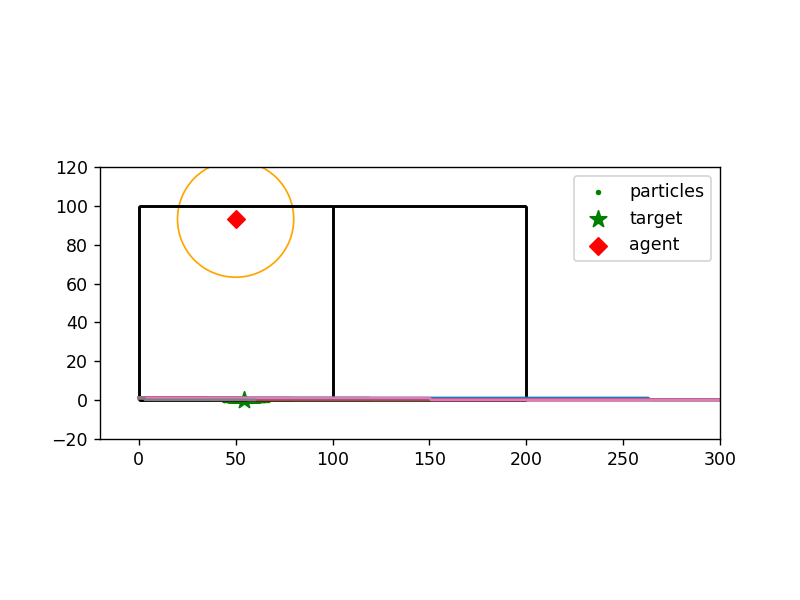

17.711321353912354


In [177]:
# create 100 particles on the roads
N = 1000
dt = 0.1
# pf = PF(r, N, dt=dt, v0=10, sigma=5)
pf = PF(r, N, dt=dt, v0=10, sigma=4)

R = 10*np.eye(2)

target = Particle(r, v0=10, dt=dt, sigma=3)

agent = Agent(center=(100, 50), width=100, height=50, period = 30, dt=dt)

# lc = mc.LineCollection(edges, colors=[(0,0,0,1)])

fig, ax = plt.subplots()
# ax.add_collection(lc)

r.visualize(ax)

x0 = pf.X[:,0]
y0 = pf.X[:,1]
# for p in pf.X:
#     loc = r.get_loc(p.state)
#     x0.append(loc[0])
#     y0.append(loc[1])

# sc = ax.scatter([40, 110], [30, 10])
sc = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='green', label='particles')
loc = r.get_loc(target.state)
sc_target = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='green', label='target')
agent.init_plot(ax)
ax.legend()
#ax.plot([50, 60], [50, 50], marker='o', ls='None')

ax.set_xlim(-20, 300)
ax.set_ylim(-20, 120)
ax.set_aspect('equal')
# plt.plot([0,1,1,2])
# plt.show()
fig.canvas.draw()
start = time.time()
Ts = dt
tic = start
# update the scenario
for i in range(int(500*Ts/Ts)):
# for i in range(1000):
    pf.predict()
    target.predict()
    dist = np.linalg.norm(target.loc - agent.pos)
#     print(dist)
    if i % int(1/Ts) == 0 and i != 0:
        if dist < agent.fov:
            z = mvn.rvs(target.loc, R)
            pf.update(z, R)
        else:
            pf.neg_update(agent.pos, radius=30)
#     locs = [p.loc for p in pf.X]
    locs = pf.X[:,:2]
    sc.set_offsets(locs)
    sc_target.set_offsets(target.loc)
    agent.update()
# sc.set_offsets([[50, 50], [130, 30]])
    fig.canvas.draw()
    toc = time.time()
    dur = toc - tic
#     if Ts > dur:
#         time.sleep(Ts - dur)
#     else:
#         print("No time to sleep! %f"%dur)
    tic = toc
dur = time.time() - start
print(dur)

In [7]:
##
import scipy.io as sio

roads = []
for a in r.graph:
    roads += [(a, b) for b in r.graph[a]]

roads = np.array(roads)


sio.savemat('single_target.mat', {'roads':roads, 'agent':agent.pos, 'X':pf.X, 'target':target.loc})

NameError: name 'agent' is not defined

## Multiple Targets##

Here we need to create a bank of particle filters to track multiple targets with perfect correspondence.

In [7]:
# intersections
i = [(0.,0.), (100.,0.), (200.,0), (0.,100), (100.,100.), (200.,100.), (0.,200), (100.,200.), (200.,200.)]
edges = [(0, 1),
         (0, 3),
         (1, 2),
         (1, 4),
         (2, 5),
         (3, 4),
         (3, 6),
         (4, 5),
         (4, 7),
         (5, 8),
         (6, 7),
         (7, 8)]

# initialize the roadmap
r = Roadmap(i, edges)

In [8]:
# intersections
i = [(0.,0.), (100.,0.), (200.,0), (300.,0),
     (0.,100), (100.,100.), (200.,100.), (300.,100.), 
     (0.,200), (100.,200.), (200.,200.), (300.,200.), 
     (0.,300), (100.,300.), (200.,300.), (300.,300.)]
edges = [(0, 1), (0, 4),
         (1, 2), (1, 5),
         (2, 3), (2, 6),
         (3, 7),
         (4, 5), (4, 8),
         (5, 6), (5, 9),
         (6, 7), (6, 10),
         (7, 11),
         (8, 9), (8, 12),
         (9, 10), (9, 13),
         (10, 11), (10, 14),
         (11, 15),
         (12, 13),
         (13, 14),
         (14, 15)]

# initialize the roadmap
r = Roadmap(i, edges)

In [ ]:
# create 100 particles on the roads
N = 200
dt = 0.1

P_fa = 0.02
P_miss = 0.05
pf1 = PF(r, N, dt=dt, v0=10, sigma=4, P_fa=P_fa, P_miss=P_miss)
pf2 = PF(r, N, dt=dt, v0=10, sigma=4, P_fa=P_fa, P_miss=P_miss)

R = 5*np.eye(2)

target1 = Particle(r, v0=10, dt=dt, sigma=2)
target2 = Particle(r, v0=10, dt=dt, sigma=2)

agent = Agent(center=(100, 50), width=100, height=50, period = 30, dt=dt)


fig, ax = plt.subplots()

r.visualize(ax)

x0 = pf1.X[:,0]
y0 = pf1.X[:,1]
# for p in pf.X:
#     loc = r.get_loc(p.state)
#     x0.append(loc[0])
#     y0.append(loc[1])

sc1 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='green', label='particles')
loc = r.get_loc(target1.state)
sc_target1 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='green', label='target')

x0 = pf2.X[:,0]
y0 = pf2.X[:,1]
# for p in pf.X:
#     loc = r.get_loc(p.state)
#     x0.append(loc[0])
#     y0.append(loc[1])
    
sc2 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='blue', label='particles')
loc = r.get_loc(target2.state)
sc_target2 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='blue', label='target')

agent.init_plot(ax)
ax.legend()
#ax.plot([50, 60], [50, 50], marker='o', ls='None')

ax.set_xlim(-20, 300)
ax.set_ylim(-20, 220)
ax.set_aspect('equal')
# plt.plot([0,1,1,2])
# plt.show()
fig.canvas.draw()
start = time.time()
Ts = dt
tic = start
# update the scenario
for i in range(int(1000/Ts)):
# for i in range(1000):
    pf1.predict()
    pf2.predict()
    target1.predict()
    target2.predict()
    dist1 = np.linalg.norm(target1.loc - agent.pos)
#     print(dist)
    if i % int(1/Ts) == 0 and i != 0:
        if dist1 < agent.fov:
            z = mvn.rvs(target1.loc, R)
            pf1.update(z, R)
        else:
            pf1.neg_update(agent.pos, radius=30)
    dist2 = np.linalg.norm(target2.loc - agent.pos)
#     print(dist)
    if i % int(1/Ts) == 0 and i != 0:
        if dist2 < agent.fov:
            z = mvn.rvs(target2.loc, R)
            pf2.update(z, R)
        else:
            pf2.neg_update(agent.pos, radius=25)
    locs1 = pf1.X[:,:2]
    sc1.set_offsets(locs1)
    locs2 = pf2.X[:,:2]
    sc2.set_offsets(locs2)
    sc_target1.set_offsets(target1.loc)
    sc_target2.set_offsets(target2.loc)
    agent.update()
# sc.set_offsets([[50, 50], [130, 30]])
    fig.canvas.draw()
    toc = time.time()
    dur = toc - tic
#     if Ts > dur:
#         time.sleep(Ts - dur)
#     else:
#         print("No time to sleep! %f"%dur)
    tic = toc
dur = time.time() - start
print(dur)

## Unknown Correspondence ##

We will use a RBPF to manage the correspondence. Each particle will contain its own bank of particle filters to track the targets. The history of measurement correspondences will be tracked by the top level RBPF.

The propogation step will be largely the same, with each particle propogating its bank of filters.

The update step will require that the low-level particle filters be able to report the likelihood of a specific measurement occuring for each target. With these probabilities in hand, we can then sample from the distribution to guess which target was the source of the measurement. In the beginning, with all target location particles being uniformly distributed, the correspondences should be chosen with equal probabilities, with convergence coming after several measurements.

In [6]:
class RB_PF(object):
    def __init__(self, roadmap, num_particles, max_vehicles, pf_args):
        self._roadmap = roadmap
        self._N = num_particles
        self._max_vehicles = max_vehicles
        self.X = [[PF(**pf_args) for j in range(self._max_vehicles)] for i in range(self._N)]
        self.best = self.X[0]
        self.no_measurements = True
        
    def lowVarSample(self, w):
        Xbar = []
        M = self._N
        r = np.random.uniform(0, 1/M)
        c = w[0]
        i = 0
        last_i = i
        unique = 1
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + w[i]
            new_x = copy.deepcopy(self.X[i])
            Xbar.append(new_x)
            if i == self.best_idx:
                self.best = new_x
            if last_i != i:
                unique += 1
            last_i = i
        self.X = Xbar
        return unique

    def predict(self):
        # propagate each bank of particle filters
        [[xi.predict() for xi in x] for x in self.X]
       
        
    def update(self, z, R, lone_target, radius=None, p_fa=None):
#         print("updating")
        w = np.zeros(self._N)
        
        

        for i, x in enumerate(self.X):
            if self.no_measurements:
                t = 0
            else:
                # get the likelihood that the measurement came from each target
                l = np.array([xi.get_measurement_likelihood(z, R) for xi in x])

                # normalize the likelihoods so we can randomly choose a corresponding target
                # with some smart probabilites
                l = l/np.sum(l)
                t = np.where(np.random.multinomial(1, l) == 1)[0][0]
    #             print(t)
            w[i] = x[t].get_measurement_likelihood(z, R)
            x[t].update(z, R)
            if lone_target:
                for j, xi in enumerate(x):
                    if t != j:
                        xi.neg_update(z, radius)
        self.no_measurements = False
            
            
        # logsumexp
        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)
#         print("best: {}={}".format(np.argmax(w), np.max(w)))
        
        self.best_idx = np.argmax(w)        
        self.best = self.X[self.best_idx]
        unique = self.lowVarSample(w)
#         print(unique)

    
    def neg_update(self, z, radius):
        [[xi.neg_update(z, radius) for xi in x] for x in self.X]

In [7]:
def calc_entropy(r, X, res=5):
    """Returns the entropy of the estimate in nats
        
        r -- roadmap graph on which the particles exist
        X -- state of each particle, shape=(M, N, 12),
             M = number of targets
             N = number of particles
        """
    
    ## x, y, speed, start_x, start_y, end_x, end_y, direction_x, direction_y, distance, sigma, w
    M = X.shape[0]
    N = X.shape[1]
    # calculate the distance of each particle from the beginning of its road segment
    dists = np.linalg.norm(X[:, :, :2] - X[:, :, 3:5], axis=-1)
    dists_reverse = np.linalg.norm(X[:, :, :2] - X[:, :, 5:6], axis=-1)
    
    h = 0
    hist = []
    nodes_visited = []
    for start in r.keys():
        if start not in nodes_visited:
            nodes_visited.append(start)
            for end in r[start].keys():
                if end not in nodes_visited:
                    nodes_visited.append(end)
                length = r[start][end]
                bin_start = 0.0
                bin_start_reverse = 1.0
                # find the particles on this road segment
                on_edge = np.all(X[:, :, 3:7] == start + end, axis=-1)
                on_edge_reverse = np.all(np.flip(X[:, :, 3:7], axis=2) == end + start, axis=-1)
                while bin_start < length:
                    in_bin = np.all([dists >= bin_start, dists <= bin_start + res], axis=0)
                    in_bin_reverse = np.all([dists_reverse >= bin_start, dists_reverse <= bin_start + res], axis=0)

                    count = np.sum(np.all([on_edge, in_bin], axis=0)) + np.sum(np.all([on_edge, in_bin_reverse], axis=0))
                    p = count / (N*M)
                    hist.append(p)
                    if p > 0:
                        h -= p*np.log(p)
                    bin_start += res
#     get_vel_var(X)
    return h, get_pos_var(X, hist), get_vel_var(X)

def get_pos_var(X, bins):
    return max(np.var(X[:,:,0:1]), np.var(X[:,:,1:2]))

def get_vel_var(X):
    return np.var(X[:,:,2:3])

In [8]:
class AgentDynamicLookaheadWithEdgeSeparationVectorized(object):
    def __init__(
        self, center, width, height, speed, period,
        roadmap, dt, fov=30.):
        self._c = center
        self._w = width
        self._h = height
        self._period = period
        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.get_nearest_waypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = speed
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0
        self.discount = 0.9

    def update(self, pfs):
#         ##Dummy version of path planning
#         self._t += self._dt
#         self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
#                              self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
#         if self._sc_agent is not None:
#             self.update_plot()
            
        ##inteligent path planning
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.update_path(pfs)

    def update_path(self, pfs):
        edges = {}
        edge_vals = {}
        
        entropies = [calc_entropy(r.graph, np.array([pf.X])) for pf in pfs]
        norm = np.sum(entropies)
        target_weights = np.array([e/norm for e in entropies])
        target_weights = 1 / (1 + np.exp(-10*(target_weights - 0.5)))
#         print(target_weights)
        
        N = [pf.X.shape[0] for pf in pfs]
        
        for i in range(len(pfs)):
            avg_den, min_den = pfs[i].get_max_particle_density()
            for j in range(len(pfs[i].X)):
                edge = ((pfs[i].X[j][3], pfs[i].X[j][4]),(pfs[i].X[j][5], pfs[i].X[j][6]))
                if edge not in edges:
                    edges[edge] = []
                    edge_vals[edge] = [0,0,0]
                particle = copy.deepcopy(pfs[i].X[j,:])
                particle = np.append(particle, i)
                edges[edge].append(particle)
                edge_vals[edge][0] += 1
                edge_vals[edge][i+1] += 1

        particle_map, best_path, best_value = self.build_particle_map(
            self.path[self.current_dest], edges, target_weights, N, 0, 0, 6)

        self.path.append(best_path[0])
        self.current_dest += 1

    def build_particle_map(self, start, edges, target_weights, N, start_value, lookahead, lookahead_max):
        if lookahead == lookahead_max:
            return start_value, [], start_value
        graph = {}

        best_path = []
        best_value = -1
    
        for destination in self._roadmap.graph[start]:
            edge0 = (start, destination)
            edge1 = (destination, start)
            value = 0
            if edge0 in edges:
                for i in range(len(target_weights)):
                    idx = np.isin(np.vstack(edges[edge0])[:,12], np.array(i))
                    val = np.sum(idx)/N[i]
                    value += target_weights[i] * val * (self.discount**lookahead)
            if edge1 in edges:
                for i in range(len(target_weights)):
                    idx = np.isin(np.vstack(edges[edge1])[:,12], np.array(i))
                    val = np.sum(idx)/N[i]
                    value += target_weights[i] * val * (self.discount**lookahead)
            new_edges = {}
            for edge in edges:
                if edge == edge0 or edge == edge1:
#                     value += len(edges[edge][0]) * (self.discount**lookahead)
                    pass
                else:
                    particles = np.array(copy.deepcopy(edges[edge]))
                    particles[:,0:2] = particles[:,0:2] + particles[:,7:9] * (particles[:,2:3] * self._dt)
                    update_vector = np.linalg.norm(particles[:,0:2] - particles[:,3:5]) > particles[:,9]
                    for particle in particles[update_vector]:
                            a = tuple(particle[3:5])
                            b = tuple(particle[5:7])

                            dest_list = list(self._roadmap.graph[b].keys())
                            dest_list.remove(a)
                            a = particle[5:7]
                            b = np.array(random.choice(dest_list))
                            vector = b - a
                            distance = np.linalg.norm(vector)
                            vector = vector/distance
                            particle[0:10] = [a[0], a[1], particle[2], a[0], a[1], b[0],
                                           b[1], vector[0], vector[1], distance]
                            new_edge = ((particle[3], particle[4]), (particle[5], particle[6]))
                            if new_edge not in new_edges:
                                new_edges[new_edge] = []
                            new_edges[new_edge].append(particle)
                    
                    
            graph[edge0], path, path_value = self.build_particle_map(
                destination, new_edges, target_weights, N, start_value + value, lookahead+1, lookahead_max)
            if path_value > best_value:
                path.insert(0, destination)
                best_path = path
                best_value = path_value
        return graph, best_path, best_value
    
    def display_particle_map(self, particle_map, indent):
        output = ""
        for edge in particle_map:
            if type(particle_map[edge]) is int:
                output += "%s%r: %f\n" % ("\t"*indent, edge, particle_map[edge])
            else:
                output += "%s%s\n" % ("\t"*indent, edge)
                output += self.displayParticleMap(particle_map[edge], indent+1)
        return output

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]

class AgentRandom(object):
    def __init__(
        self, center, width, height, speed, period,
        roadmap, dt, fov=30.):
        self._c = center
        self._w = width
        self._h = height
        self._period = period
        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.get_nearest_waypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = speed
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0
        self.discount = .8

    def update(self, pfs):
#         ##Dummy version of path planning
#         self._t += self._dt
#         self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
#                              self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
#         if self._sc_agent is not None:
#             self.update_plot()
            
        ##inteligent path planning
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.update_path(pfs)

    def update_path(self, pfs):
        destinations = list(self._roadmap.graph[self.path[self.current_dest]].keys())
        self.path.append(random.choice(destinations))
        self.current_dest += 1

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]

class AgentSimple(object):
    def __init__(
        self, center, width, height, speed, period,
        roadmap, dt, fov=30.):
        self._c = center
        self._w = width
        self._h = height
        self._period = period
        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.get_nearest_waypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = speed
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0
        self.discount = .8

    def update(self, pfs):
#         ##Dummy version of path planning
#         self._t += self._dt
#         self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
#                              self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
#         if self._sc_agent is not None:
#             self.update_plot()
            
        ##inteligent path planning
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 5:
            self.update_path(pfs)

    def update_path(self, pfs):
        destinations = list(self._roadmap.graph[self.path[self.current_dest]].keys())
        if len(self.path) > 1:
            destinations.remove(self.path[self.current_dest-1])
        self.path.append(random.choice(destinations))
        self.current_dest += 1

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]


In [9]:
def sim(rpbf, targets, agent, R, dt, T_end, plot=True):
    if plot:
        fig, ax = plt.subplots()
        r.visualize(ax)

        x0 = rbpf.best[0].X[:,0]
        y0 = rbpf.best[0].X[:,1]
        sc1 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='green', label='particles')
        loc = r.get_loc(target1.state)
        sc_target1 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='green', label='target')

    #     x0 = rbpf.best[1].X[:,0]
    #     y0 = rbpf.best[1].X[:,1]
    #     sc2 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='blue', label='particles')
    #     loc = r.get_loc(target2.state)
    #     sc_target2 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='blue', label='target')
        agent.init_plot(ax)
        ax.legend()
        #ax.plot([50, 60], [50, 50], marker='o', ls='None')

        ax.set_xlim(-20, 450)
        ax.set_ylim(-20, 320)
        ax.set_aspect('equal')
        # plt.plot([0,1,1,2])
        # plt.show()
        fig.canvas.draw()
        start = time.time()
        tic = start
    H = []
    Ts = dt
    avg_distance = [[] for pf in rbpf.best]
    num_in_threshold = [[] for pf in rbpf.best]
    variances = [[],[]]
    
    # update the scenario
    for i in range(int(T_end/Ts)):
        rbpf.predict()
        dists = []
        for target in targets:
            target.predict()
            dists.append(np.linalg.norm(target.loc - agent.pos))
            
        if i % int(1/Ts) == 0 and i != 0:
#             if (dist1 < agent.fov) != (dist2 < agent.fov):
            if dists[0] < agent.fov:
                z = mvn.rvs(targets[0].loc, R)
                rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
#                 if dist2 < agent.fov:
#                     z = mvn.rvs(target2.loc, R)
#                     rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
#             elif (dist1 < agent.fov) and (dist2 < agent.fov):
#                     z = mvn.rvs(target1.loc, R)
#                     rbpf.update(z, R, lone_target=False)
#                     z = mvn.rvs(target2.loc, R)
#                     rbpf.update(z, R, lone_target=False)
            else:
                rbpf.neg_update(agent.pos, radius=agent.fov*0.75)
        if plot:
            locs1 = rbpf.best[0].X[:,:2]
            sc1.set_offsets(locs1)
    #         locs2 = rbpf.best[1].X[:,:2]
    #         sc2.set_offsets(locs2)
            sc_target1.set_offsets(target1.loc)
    #         sc_target2.set_offsets(target2.loc)
            pfs = rbpf.best
        pfs = rbpf.best
        agent.update(pfs)
        if plot:
            fig.canvas.draw()
            toc = time.time()
            dur = toc - tic
            tic = toc
        X = np.array([rbpf.best[i].X for i in range(len(rbpf.best))])
        H_current, var_pos, var_vel = calc_entropy(r.graph, X)
        H += [H_current]
        variances[0].append(var_pos)
        variances[1].append(var_vel)

    return H, variances

In [ ]:
N = 500
dt = 0.1
T_end = 600
num_runs = 200

P_fa = 0.02
P_miss = 0.05
pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':10, 'sigma':4, 'P_fa':P_fa, 'P_miss':P_miss}
R = 5*np.eye(2)
H = []

for i in tqdm(range(num_runs)):
    try:
        rbpf = RB_PF(r, 10, 2, pf_args)

        target1 = Particle(r, v0=10, dt=dt, sigma=2)
        target2 = Particle(r, v0=10, dt=dt, sigma=2)
        targets = [target1, target2]

        agent = AgentDynamicLookaheadWithEdgeSeparationVectorized((100, 60), 100, 50, 40, 30, r, dt=dt)
#         agent = AgentRandom((100, 60), 100, 50, 40, 30, r, dt=dt)

        H += [sim_without_plotting(rbpf, targets, agent, R, dt, T_end)]
#         H += [sim(rbpf, targets, agent, R, dt, T_end)]
    except:
        pass

h = np.mean(H, axis=0)
fig, ax = plt.subplots()
ax.plot(h)
f_name = 'data/dynamic_lookahead_N-{}_T-{}_MC-{}__{}.mat'.format(N, T_end, num_runs, str(datetime.datetime.now()))
sio.savemat(f_name, {'H':H})

In [ ]:
import datetime
f_name = 'data/dynamic_lookahead_N-{}_T-{}_MC-{}__{}.mat'.format(N, T_end, num_runs, str(datetime.datetime.now()))
sio.savemat(f_name, {'H':H})
h = np.mean(H, axis=0)
fig, ax = plt.subplots()
ax.plot(h)

In [ ]:
import scipy.io as sio


sio.savemat('Dynamic_Lookahead_L_N-500_T-600_MC-1.mat', {'H':H})

In [ ]:
# s = 4
# np.random.seed(s)
# random.seed(s)

N = 500
dt = 0.1
T_end = 600
num_runs = 20

P_fa = 0.02
P_miss = 0.05
pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':10, 'sigma':4, 'P_fa':P_fa, 'P_miss':P_miss}
R = 5*np.eye(2)
H = []

rbpf = RB_PF(r, 10, 2, pf_args)

target1 = Particle(r, v0=10, dt=dt, sigma=2)
target2 = Particle(r, v0=10, dt=dt, sigma=2)
targets = [target1, target2]

agent = AgentDynamicLookaheadWithEdgeSeparationVectorized((100, 60), 100, 50, 40, 30, r, dt=dt)
# agent = AgentRandom((100, 60), 100, 50, 40, 30, r, dt=dt)

H += [sim(rbpf, targets, agent, R, dt, T_end)]

In [ ]:
fig, ax = plt.subplots()
ax.plot(H[0])

In [ ]:
import scipy.io as sio

roads = []
for a in r.graph:
    roads += [(a, b) for b in r.graph[a]]

roads = np.array(roads)

X1 = rbpf.best[0].X
X2 = rbpf.best[1].X

sio.savemat('multi_target.mat', {'roads':roads, 'agent':agent.pos, 'X1':X1, 'X2':X2, 
                                 'target1':target1.loc, 'target2':target2.loc})

## Theorem Verification: simple map ##

Using a simple map, with no intersections we verify whether or not the theorem holds for average lower bound

<IPython.core.display.Javascript object>


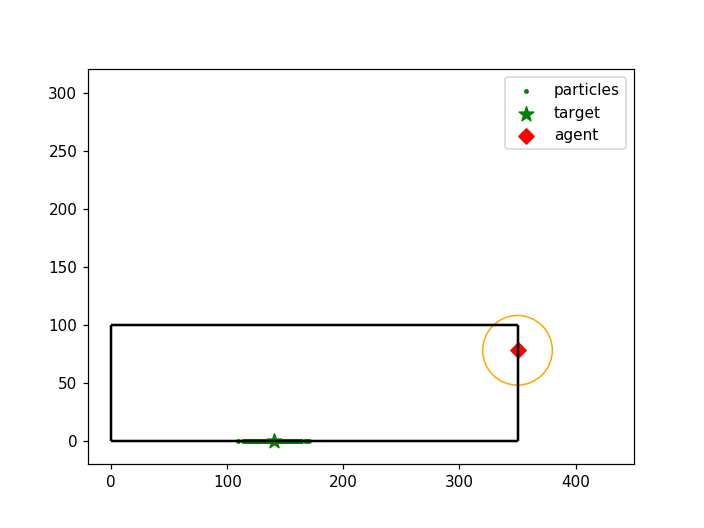

In [12]:
Va = 30
dist_e = 350
# intersections
i = [(0.,0.), (dist_e,0.),
     (0.,100), (dist_e,100)]
edges = [(0, 1), 
         (0, 2), 
         (1, 3),
         (2, 3)]

# initialize the roadmap
r = Roadmap(i, edges)

sigma_vel = 10

N = 1000
dt = 0.1
T_end = 50
# num_runs = 10

P_fa = 0.02
P_miss = 0.05
pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':0, 'sigma':sigma_vel, 'P_fa':P_fa, 'P_miss':P_miss}
R = 5*np.eye(2)
H = []

target1 = Particle(r, v0=0, dt=dt, e0=((0,0),(dist_e,0)), x0=.4, sigma=2)
target2 = Particle(r, v0=0, dt=dt, sigma=2)
targets = [target1]#, target2]
rbpf = RB_PF(r, 10, len(targets), pf_args)

Va = 30
agent = AgentSimple((dist_e/2, 0), 100, 50, Va, 30, r, dt=dt)
# agent = AgentRandom((100, 60), 100, 50, 40, 30, r, dt=dt)

H_current, variances = sim(rbpf, targets, agent, R, dt, T_end)
H += [H_current]

## Compare simulation Variance in Position with estimate Var=Var_Initial + t*dt^2*sigma_v^2

In [45]:
## Calculate variance and sigma for a single run
from scipy.signal import savgol_filter
def calculateAndPlotVarianceAndSigma(H, plot=True):

    data = H[0]
    if plot:
    #     yhat = savgol_filter(data, 51, 2)
        fig, ax = plt.subplots()
        ax.plot(data, label='raw')
        # ax.plot(yhat, label='smoothed')
        # ax.plot(np.convolve(data), label='convolved')
        # ax.legend()
        ax.set_title("Entropy")

    ## Process Variance data to get the mins and maxs for positional variance and estimate the slope
    period = 400 #(dist_e*2 + 100*2)/Va
    next_min = 0
    next_max = 330
    var_y = []
    var_x = []
    first_min = None
    first_max = None
    while(next_max > next_min+30):
        next_min = variances[0].index(np.nanmin(variances[0][next_max:next_max+100]))
        next_max = variances[0].index(np.nanmax(variances[0][next_min:next_min+period]))
        if first_min is None:
            first_min = next_min
            first_max = next_max
        var_y.extend([variances[0][next_min], variances[0][next_max]])
        var_x.extend([next_min,next_max])
    sigma_pos_est_slope = []
    for i in range(0, len(var_y), 2):
        if var_x[i+1] != var_x[i]:
            sigma_pos_est_slope.append((var_y[i+1]-var_y[i])/(var_x[i+1]-var_x[i]))
    sigma_pos_est = []
    for i in range(0, len(var_x)-2, 2):
        sigma_pos_est.append(var_y[i])
        sigma_pos_est.append(var_y[i] + (var_x[i+1]-var_x[i])*sigma_pos_est_slope[int(i/2)])


    var_y_np = np.array(var_y)
    var_x_np = np.array(var_x)
    minimum = min(data)
    minimum_index = data.index(minimum)
    maximum = max(data[minimum_index:minimum_index+500])
    maximum_index = data.index(maximum)
    starting_index = first_min#var_x[0]

    ## Variance for velocity and position
    positional_variance = variances[0][starting_index:]
    velocity_variance = variances[1][starting_index:]
    window = 30
    for i in range(window, len(velocity_variance)-window):
        if (velocity_variance[i] != velocity_variance[i-window] and velocity_variance[i] != velocity_variance[i+window]):
            velocity_variance[i] = velocity_variance[i-window]

    if plot:
        fig, ax1 = plt.subplots()
        ax1.plot(variances[0][starting_index:], 'b-', label='positional variance')
        ax2 = ax1.twinx()
        ax2.plot(velocity_variance[starting_index:], 'g-', label='velocity variance')
        ax1.set_title('Variance')
        ax1.set_ylabel("Positional Variance", color='b')
        ax2.set_ylabel("Velocity Variance", color='g')
        ax1.set_xlabel("time in dt")
        ax1.legend()


    ## Standard deviation for both velocity and position over time
    positional_sigma = np.sqrt(variances[0][starting_index:])
    velocity_sigma = np.sqrt(variances[1][starting_index:])
    window = 30
    for i in range(window, len(velocity_sigma)-window):
        if (velocity_sigma[i] != velocity_sigma[i-window] and velocity_sigma[i] != velocity_sigma[i+window]):
            velocity_sigma[i] = velocity_sigma[i-window]

    if plot:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(positional_sigma, 'b-', label='positional')
        ax1.plot(var_x, np.sqrt(var_y), 'r-', label='positional_estimate_1')
        ax1.plot(var_x[:len(sigma_pos_est)], np.sqrt(sigma_pos_est), 'm-', label='positional_estimate_2')
        ax2.plot(velocity_sigma, 'g-', label='velocity smoothed')
        ax1.set_title('Standard Deviation')
        ax1.set_ylabel("Positional Sigma", color='b')
        ax2.set_ylabel("Velocity Sigma Smoothed", color='g')
        ax1.set_xlabel("time in dt")
        ax1.legend()

    velocity_sigma_unique = [velocity_sigma[0]]
    for i in range(len(velocity_sigma)):
        if velocity_sigma[i] != velocity_sigma_unique[-1]:
            velocity_sigma_unique.append(velocity_sigma[i])

#     print("Index: ({},{}) Value: ({},{}), Slope: {}".format(
#             first_min, first_max, 
#             variances[0][first_min], variances[0][first_max],
#             (variances[0][first_max]-variances[0][first_min])/(first_max-first_min)))
    est = variances[0][first_min] + (first_max-first_min)*dt**2*sigma_vel**2-variances[0][first_min]
    actual = variances[0][first_max] - variances[0][first_min]
    return est, actual

<IPython.core.display.Javascript object>


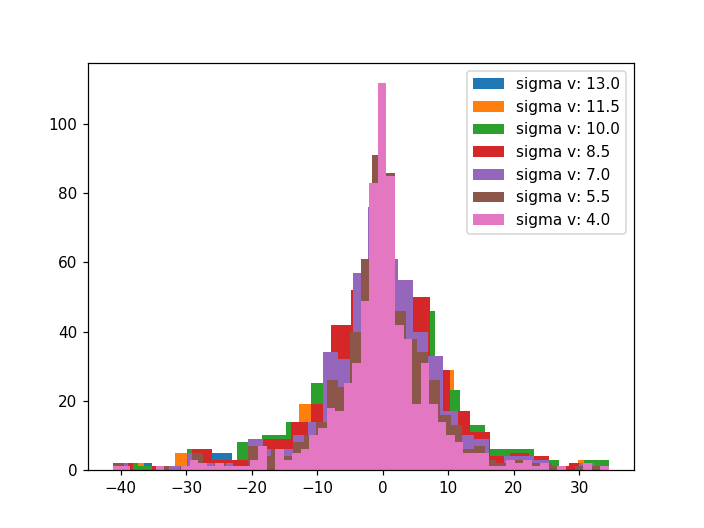

In [162]:
Va = 30
dist_e = 350
# intersections
i = [(0.,0.), (dist_e,0.),
     (0.,100), (dist_e,100)]
edges = [(0, 1), 
         (0, 2), 
         (1, 3),
         (2, 3)]

# initialize the roadmap
r = Roadmap(i, edges)


N = 1000
dt = 0.1
T_end = 50
# num_runs = 10

P_fa = 0.02
P_miss = 0.05
R = 5*np.eye(2)
H = []

target1 = Particle(r, v0=0, dt=dt, e0=((0,0),(dist_e,0)), x0=.4, sigma=2)
target2 = Particle(r, v0=0, dt=dt, sigma=2)
targets = [target1]#, target2]

Va = 30
agent = AgentSimple((dist_e/2, 0), 100, 50, Va, 30, r, dt=dt)
# agent = AgentRandom((100, 60), 100, 50, 40, 30, r, dt=dt)
diff = []
estimates = []
actuals = []

fig, ax = plt.subplots()
for i in reversed(range(7)):
    sigma_vel = 4 + i*1.5
    pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':0, 'sigma':sigma_vel, 'P_fa':P_fa, 'P_miss':P_miss}
    rbpf = RB_PF(r, 10, len(targets), pf_args)
    for j in tqdm(range(100)):
        H_current, variances = sim(rbpf, targets, agent, R, dt, T_end, plot=False)
        H += [H_current]
    #     print(calculateAndPlotVarianceAndSigma(H, plot=False))
        est, actual = calculateAndPlotVarianceAndSigma(H, plot=False)
        estimates.append(est)
        actuals.append(actual)
        diff.append(est-actual)

    clean_actuals = []
    clean_estimates = []
    clean_diff = []
    for i in range(len(actuals)):
        if actuals[i] > 0:
            clean_actuals.append(actuals[i])
            clean_estimates.append(estimates[i])
            clean_diff.append(diff[i])
    ax.hist(clean_diff, bins='auto', label="sigma v: {}".format(sigma_vel))
ax.legend()

<IPython.core.display.Javascript object>


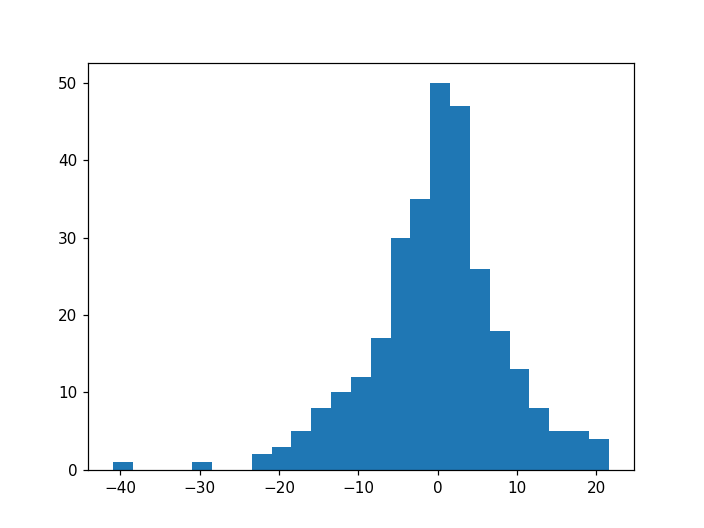

In [49]:

plt.hist(clean_diff, bins='auto')
plt.show()

### Average Distance between targets
Using Djikstras to identify the average distance between all nodes we can obtain an average distance between any two targets over the course of a simulation

In [52]:
def DjikstraGraph(graph, initial_node):
    nodes = sorted(graph.keys())
    unvisited = sorted(graph.keys())
    visited = []
    dists = []
    paths = []
    for node in nodes:
#         if node == initial_node:
#             continue
        dists.append(np.inf)
        paths.append([])
        if node == initial_node:
            dists[-1] = 0
    while len(visited) < len(nodes):
        best_node = None
        best_node_val = -1
        for node in unvisited:
            if dists[nodes.index(node)] < best_node_val or best_node is None:
                best_node_val = dists[nodes.index(node)]
                best_node = node
        start_node = best_node
        visited.append(start_node)
        unvisited.remove(start_node)
        index_start = nodes.index(start_node)
        for node in graph[start_node].keys():
            index = nodes.index(node)
            new_dist = dists[index_start] + graph[start_node][node]
            if new_dist < dists[index]:
                dists[index] = new_dist
                paths[index] = paths[index_start]
                paths[index].append(node)
    return dists

def getAvgDistance(r):
    vals = []
    for node in sorted(r.graph.keys()):
#         print(DjikstraGraph(r.graph, node))
        avgs = np.array(DjikstraGraph(r.graph, node))
        
        avg_dist = np.mean(avgs[avgs>0])
#         print(avg_dist, avgs)
#         print(avgs[avgs>0])
        vals.append(avg_dist)
    return np.mean(vals)

def getShortestPath(graph, start_edge, start_percent, r, target_edge, target_percent, depth):
    nodes = sorted(graph.keys())
    start_index0 = nodes.index(start_edge[0])
    start_index1 = nodes.index(start_edge[1])
    end_index0 = nodes.index(target_edge[0])
    end_index1 = nodes.index(target_edge[1])
#     print(edge, target)
#     print(start_index0, start_index1, end_index0, end_index1)
    
    dist_from_start0 = DjikstraGraph(graph, start_edge[0])
    dist_from_start1 = DjikstraGraph(graph, start_edge[1])
    
    dist_to_start_node = [
        graph[start_edge[0]][start_edge[1]]*start_percent,
        graph[start_edge[1]][start_edge[0]]*(1-start_percent)]

    dist_to_point = [
        graph[target_edge[0]][target_edge[1]]*target_percent,
        graph[target_edge[1]][target_edge[0]]*(1-target_percent)]
    
    distances = [
        dist_to_start_node[0] + dist_from_start0[end_index0] + dist_to_point[0],
        dist_to_start_node[0] + dist_from_start0[end_index1] + dist_to_point[1],
        dist_to_start_node[1] + dist_from_start1[end_index0] + dist_to_point[0],
        dist_to_start_node[1] + dist_from_start1[end_index1] + dist_to_point[1]
    ]
    if start_edge == target_edge:
        distances.append(graph[start_edge[0]][start_edge[1]]*abs(start_percent-target_percent))
    elif (start_edge[1], start_edge[0]) == target_edge:
        distances.append(graph[start_edge[0]][start_edge[1]]*abs((1-start_percent)-target_percent))
        
    return min(distances)

In [53]:
def createGridLayout(x,y,min_edge_length, max_edge_length):
    nodes = []
    edges = []
    for i in range(y):
        for j in range(x):
            x_val = 0
            y_val = 0
            if i > 0:
                y_val = nodes[(i-1)*x + j][1]+ np.random.uniform(low=min_edge_length, high=max_edge_length)
            if j > 0:
                x_val = nodes[i*x+j-1][0]+ np.random.uniform(low=min_edge_length, high=max_edge_length)
            nodes.append((
                x_val,
                y_val ))

    for i in range(y):
        for j in range(x-1):
            edges.append((j+x*i,j+1+x*i))
    
    for i in range(y-1):
        for j in range(x):
            edges.append((j+x*i,j+x*(i+1)))
    return [nodes, edges]

In [54]:
## Get average distance between any two particles at initialization on given map
Va = 30
data = []
for i in range(1,5):
#     print()
    dist_e = i*100
    layouts = [
        (2,2),(2,3),(2,4),(2,5),(2,6),(2,7),(2,8),(2,9),
        (3,3),(3,4),(3,5),(3,6),(3,7),(3,8),(3,9),
        (4,4),(4,5),(4,6),(4,7),(4,8),(4,9),
        (5,5),(5,6),(5,7),(5,8),(5,9),
        (6,6),(6,7),(6,8),(6,9),
        (7,7),(7,8),(7,9),
        (8,8),(8,9),
        (9,9)
    ]

    for layout in layouts:
        nodes, edges = createGridLayout(layout[0], layout[1], dist_e, dist_e)
#         nodes = layout[0]
#         edges = layout[1]
        r = Roadmap(nodes, edges)
        N = 1000
        dt = .1
        T_end = 50
        # num_runs = 10

        P_fa = 0.02
        P_miss = 0.05
        R = 5*np.eye(2)
        H = []
        total_value = 0
        num_runs=1000
        max_depth = 10
        for i in range(num_runs):
            target1 = Particle(r, v0=0, dt=dt, sigma=2)
            target2 = Particle(r, v0=0, dt=dt, sigma=2)
            start_edge = target1._e
            options = [(start_edge, target1._x), ((start_edge[1], start_edge[0]), 1-target1._x)]

            best_path = None
            best_value = -1

            shortest_path_value = getShortestPath(r.graph, target1._e, target1._x, r, target2._e, target2._x, max_depth)

            total_value += shortest_path_value
        total_value += best_value
        data.append([
            dist_e,
            layout,
            total_value/num_runs,
            getAvgDistance(r),
            total_value/num_runs,
            dist_e*len(edges)
        ])
        print("EdgeLength: {} Layout: {} estimate: {:.2f}, actual: {:.2f} Total Map Length: {}".format(
            data[-1][0], data[-1][1], data[-1][3], data[-1][4], data[-1][5]
        ))

EdgeLength: 100 Layout: (2, 2) estimate: 133.33, actual: 99.53 Total Map Length: 400
EdgeLength: 100 Layout: (2, 3) estimate: 166.67, actual: 133.18 Total Map Length: 700
EdgeLength: 100 Layout: (2, 4) estimate: 200.00, actual: 175.87 Total Map Length: 1000
EdgeLength: 100 Layout: (2, 5) estimate: 233.33, actual: 199.58 Total Map Length: 1300
EdgeLength: 100 Layout: (2, 6) estimate: 266.67, actual: 242.54 Total Map Length: 1600
EdgeLength: 100 Layout: (2, 7) estimate: 300.00, actual: 272.14 Total Map Length: 1900
EdgeLength: 100 Layout: (2, 8) estimate: 333.33, actual: 317.27 Total Map Length: 2200
EdgeLength: 100 Layout: (2, 9) estimate: 366.67, actual: 343.14 Total Map Length: 2500
EdgeLength: 100 Layout: (3, 3) estimate: 200.00, actual: 172.48 Total Map Length: 1200
EdgeLength: 100 Layout: (3, 4) estimate: 233.33, actual: 204.63 Total Map Length: 1700
EdgeLength: 100 Layout: (3, 5) estimate: 266.67, actual: 243.94 Total Map Length: 2200
EdgeLength: 100 Layout: (3, 6) estimate: 300.0

EdgeLength: 300 Layout: (5, 6) estimate: 1100.00, actual: 1058.17 Total Map Length: 14700
EdgeLength: 300 Layout: (5, 7) estimate: 1200.00, actual: 1178.42 Total Map Length: 17400
EdgeLength: 300 Layout: (5, 8) estimate: 1300.00, actual: 1244.47 Total Map Length: 20100
EdgeLength: 300 Layout: (5, 9) estimate: 1400.00, actual: 1364.68 Total Map Length: 22800
EdgeLength: 300 Layout: (6, 6) estimate: 1200.00, actual: 1182.70 Total Map Length: 18000
EdgeLength: 300 Layout: (6, 7) estimate: 1300.00, actual: 1240.27 Total Map Length: 21300
EdgeLength: 300 Layout: (6, 8) estimate: 1400.00, actual: 1353.69 Total Map Length: 24600
EdgeLength: 300 Layout: (6, 9) estimate: 1500.00, actual: 1456.38 Total Map Length: 27900
EdgeLength: 300 Layout: (7, 7) estimate: 1400.00, actual: 1376.55 Total Map Length: 25200
EdgeLength: 300 Layout: (7, 8) estimate: 1500.00, actual: 1475.89 Total Map Length: 29100
EdgeLength: 300 Layout: (7, 9) estimate: 1600.00, actual: 1551.11 Total Map Length: 33000
EdgeLength

As can be seen the error is fairly small regardless of layout however there is variation based on layout type and map size. When run over an extended period of time however all errors drop to less than 1 unit regardless of map type or map size

In [48]:
def getAverageDistanceOverSim(v0, dt, r, duration=40):
    target1 = Particle(r, v0=v0, dt=dt, sigma=4)
    target2 = Particle(r, v0=v0, dt=dt, sigma=4)
    total_distance = 0
    for i in range(duration):
#         print('test', i)
        shortest_path_value = getShortestPath(r.graph, target1._e, target1._x, r, target2._e, target2._x, max_depth)
        total_distance += shortest_path_value
        target1.predict()
        target2.predict()
    return total_distance/duration

def getAverageErrorForLayout(layout, edge_length, v0, dt, num_runs, sim_duration):
    nodes, edges = createGridLayout(layout[0], layout[1], 0, edge_length)
    r = Roadmap(nodes, edges)
    total_distance = 0
    for j in range(num_runs):
        avg_distance = getAverageDistanceOverSim(v0, dt, r, duration=sim_duration)
        total_distance += avg_distance

    estimated_dist = getAvgDistance(r)
#     print(estimated_dist, total_distance/num_runs, num_runs)
    error = estimated_dist - total_distance/num_runs
    return error

def getAverageErrorForLayoutType(layout, edge_length, v0, dt, num_iterations, num_runs, sim_duration):
    dt = .1
    total_error = 0
    for i in tqdm(range(num_iterations)):
        error = getAverageErrorForLayout(layout, edge_length, v0, dt, num_runs, sim_duration)
#         print(error)
        total_error += error
    return total_error/num_iterations


In [ ]:
## Get the difference between the djikstra estimate and the average distance between targets
# over an extended simulation time
## Get average distance between any two particles on given map
Va = 30
data = []
for i in reversed(range(1,5)):
    print()
    dist_e = i*100
    layouts = [
        (2,2),#(2,3),(2,4),(2,5),(2,6),(2,7),(2,8),(2,9),
#         (3,3),#(3,4),(3,5),(3,6),(3,7),(3,8),(3,9),
#         (4,4),#(4,5),(4,6),(4,7),(4,8),(4,9),
        (5,5),#(5,6),(5,7),(5,8),(5,9),
#         (6,6),#(6,7),(6,8),(6,9),
#         (7,7),#(7,8),(7,9),
#         (8,8),#(8,9),
        (9,9)
    ]

    for layout in layouts:
        dt = .1

#         total_value = 0
        total_error = 0
        num_iterations=10
        num_runs = 1000
#         sim_time = 0
#         max_depth = 10
        for i in tqdm(range(num_iterations)):
            error = getAverageErrorForLayout(layout, dist_e, 10, dt, num_runs, 1000)
            total_error += error
#             total_value += shortest_path_value
#         total_value += best_value
        data.append([
            dist_e,
            layout,
#             total_value/num_runs,
#             getAvgDistance(r),
#             abs(total_value/num_runs - getAvgDistance(r)),
            total_error /num_runs
#             dist_e*len(edges)
        ])
        print("EdgeLength: {} Layout: {} error: {:.2f}".format(
            data[-1][0], data[-1][1], data[-1][2]
        ))


EdgeLength: 400 Layout: (2, 2) error: -0.16



EdgeLength: 400 Layout: (5, 5) error: -0.19


## Estimated Average Distance Between Targets

In [77]:
Va = 30
dist_e = 350
# intersections
i = [(0.,0.), (dist_e,0.),
     (0.,100), (dist_e,100)]
edges = [(0, 1), 
         (0, 2), 
         (1, 3),
         (2, 3)]

# initialize the roadmap
r = Roadmap(i, edges)


N = 1000
dt = 0.1
T_end = 50
# num_runs = 10

P_fa = 0.02
P_miss = 0.05
R = 5*np.eye(2)
H = []

for i in range(10):
    target1 = Particle(r, v0=0, dt=dt, sigma=2)
    target2 = Particle(r, v0=0, dt=dt, sigma=2)
    print(target1._e, target1._x, target2._e, target2._x)

((700.0, 1050.0), (700.0, 700.0)) 0.03813713407181085 ((700.0, 700.0), (700.0, 1050.0)) 0.06111443270828676
((700.0, 700.0), (700.0, 1050.0)) 0.10769756385715301 ((350.0, 1050.0), (350.0, 700.0)) 0.3867465260457362
((350.0, 700.0), (700.0, 700.0)) 0.8324135175940807 ((350.0, 700.0), (350.0, 1050.0)) 0.5092382999251642
((350.0, 1050.0), (700.0, 1050.0)) 0.9854173732896551 ((350.0, 700.0), (700.0, 700.0)) 0.2707931324105085
((350.0, 350.0), (700.0, 350.0)) 0.2329961859675801 ((700.0, 350.0), (350.0, 350.0)) 0.9626342085410501
((350.0, 1050.0), (350.0, 700.0)) 0.34882290516080117 ((700.0, 350.0), (350.0, 350.0)) 0.11119483515539652
((350.0, 1050.0), (700.0, 1050.0)) 0.7789451198343619 ((700.0, 1050.0), (700.0, 700.0)) 0.059656236057233136
((350.0, 700.0), (700.0, 700.0)) 0.8442249672984753 ((700.0, 1050.0), (700.0, 700.0)) 0.7858454217691074
((700.0, 700.0), (350.0, 700.0)) 0.9385476600387356 ((700.0, 350.0), (350.0, 350.0)) 0.004679691865973279
((700.0, 1050.0), (350.0, 1050.0)) 0.080465

## Mode Splitting

### Probablity of encountering an intersection

In [98]:
dist_e = 100
nodes = [(0.,0.), (dist_e,0.), (2*dist_e, 0),
     (0.,dist_e), (dist_e,dist_e), (2*dist_e, dist_e)]
edges = [(0, 1), 
         (0, 3),
         (1, 2),
         (1, 4),
         (2, 5),
         (3, 4),
         (4, 5)
        ]
r = Roadmap(nodes, edges)
T_end = 50
target1 = Particle(r, v0=10, dt=dt, sigma=0)


In [14]:
def targetSim(targets, dt, T_end, plot=True):
    if plot:
        fig, ax = plt.subplots()
        r.visualize(ax)

        loc = r.get_loc(target1.state)
        sc_target1 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='green', label='target')

        ax.legend()

        ax.set_xlim(-20, 450)
        ax.set_ylim(-20, 320)
        ax.set_aspect('equal')
        # plt.plot([0,1,1,2])
        # plt.show()
        fig.canvas.draw()
        start = time.time()
        tic = start
    Ts = dt
    modes_over_sim = []
    # update the scenario
    for i in range(int(T_end/Ts)):
        mode_splits = {}
        for target in targets:
            target.predict()
            if target.split > 1:
                if target.split not in mode_splits:
                    mode_splits[target.split] = 0
                mode_splits[target.split] += 1
#                 mode_split += 1
#                 print(target.split)
#                 print(mode_splits)
        modes_over_sim.append(mode_splits)
        if plot:
            sc_target1.set_offsets(target1.loc)
            fig.canvas.draw()
            toc = time.time()
            dur = toc - tic
            tic = toc

    return modes_over_sim
# print(sim([target1], dt, T_end))

In [40]:
number_of_splits = 0
num_runs = 100000
vel = 10
T_end = 600
nodes, edges = createGridLayout(2,3,dist_e, dist_e)
r = Roadmap(nodes, edges)
for i in tqdm(range(num_runs)):
    targets = [Particle(r, v0=vel, dt=dt, sigma=0)]
    mode_splits = targetSim(targets, dt, T_end, plot=False)
#     print(mode_splits)
    for split in mode_splits:
        if 2 in split:
#             print('test')
            number_of_splits += split[2]
print(number_of_splits)
prob = (number_of_splits/num_runs)/T_end
print(prob)
    

2575606
0.04292676666666667


In [41]:
unknown = dist_e * prob / 10
# 20*.439148/dist_e
print(10*unknown/dist_e)
# print(Prob)

0.04292676666666667


In [42]:
#2 - number of intersections of that type
#3 - number of edges approaching intersection
#7 - number of edges in map
#dist_e - length of edges
#2*7*dist_e - (bidirectional)(number of edges)(length of edge)
probability_of_split = (2*3*vel)/(2*7*dist_e)
print(probability_of_split)

0.04285714285714286


### Rate of mode splitting

In [49]:
def sim(rpbf, targets, agent, R, dt, T_end, plot=True):
    if plot:
        fig, ax = plt.subplots()
        r.visualize(ax)

        x0 = rbpf.best[0].X[:,0]
        y0 = rbpf.best[0].X[:,1]
        sc1 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='green', label='particles')
        loc = r.get_loc(targets[0].state)
        sc_target1 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='green', label='target')

    #     x0 = rbpf.best[1].X[:,0]
    #     y0 = rbpf.best[1].X[:,1]
    #     sc2 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='blue', label='particles')
    #     loc = r.get_loc(target2.state)
    #     sc_target2 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='blue', label='target')
#         agent.init_plot(ax)
        ax.legend()
        #ax.plot([50, 60], [50, 50], marker='o', ls='None')

        ax.set_xlim(-20, 450)
        ax.set_ylim(-20, 320)
        ax.set_aspect('equal')
        # plt.plot([0,1,1,2])
        # plt.show()
        fig.canvas.draw()
        start = time.time()
        tic = start
    H = []
    Ts = dt
    avg_distance = [[] for pf in rbpf.best]
    num_in_threshold = [[] for pf in rbpf.best]
    variances = [[],[]]
    last_mode = 0
    # update the scenario
    for i in range(int(T_end/Ts)):
        if i < 20:
            z = mvn.rvs(targets[0].loc, R)
            rbpf.update(z, R, lone_target=True, radius=.1)
        rbpf.predict()
        dists = []
        for target in targets:
            target.predict()
            dists.append(np.linalg.norm(target.loc - agent.pos))
            
#         if i % int(1/Ts) == 0 and i != 0:
# #             if (dist1 < agent.fov) != (dist2 < agent.fov):
#             if dists[0] < agent.fov:
#                 z = mvn.rvs(targets[0].loc, R)
#                 rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
# #                 if dist2 < agent.fov:
# #                     z = mvn.rvs(target2.loc, R)
# #                     rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
# #             elif (dist1 < agent.fov) and (dist2 < agent.fov):
# #                     z = mvn.rvs(target1.loc, R)
# #                     rbpf.update(z, R, lone_target=False)
# #                     z = mvn.rvs(target2.loc, R)
# #                     rbpf.update(z, R, lone_target=False)
#             else:
#                 rbpf.neg_update(agent.pos, radius=agent.fov*0.75)
        if plot:
            locs1 = rbpf.best[0].X[:,:2]
            sc1.set_offsets(locs1)
    #         locs2 = rbpf.best[1].X[:,:2]
    #         sc2.set_offsets(locs2)
            sc_target1.set_offsets(targets[0].loc)
    #         sc_target2.set_offsets(target2.loc)
            pfs = rbpf.best
        pfs = rbpf.best
#         agent.update(pfs)
        if plot:
            fig.canvas.draw()
            toc = time.time()
            dur = toc - tic
            tic = toc
        X = np.array([rbpf.best[i].X for i in range(len(rbpf.best))])
#         print(X[0,:,0:2].shape)
        modes = getNumberOfModes(X[0,:,0:2], 1,1,50)
        if modes != last_mode:
#             print(modes)
            last_mode = modes
#         H_current, var_pos, var_vel = calc_entropy(r.graph, X)
#         H += [H_current]
#         variances[0].append(var_pos)
#         variances[1].append(var_vel)

    return H, variances

In [50]:
# particles = np.array([rbpf.best[i].X for i in range(len(rbpf.best))])
def getNumberOfModes(particles, starting_size, growth_factor, N):
    num_modes = 0
    while len(particles) > 0:
        mode_width = starting_size
        center = particles[0,0:2]
        mode_size_old = -1
        mode_size = 0
        mode_increase = 0
        while mode_size != mode_size_old: # While the change in mean or mode size captures more particles
            mode_width += growth_factor
            mode_size_old = mode_size
            dists = np.mean(particles[:,0:2] - center, axis=1) # Get the distance from all unclaimed particles to the estimated center
            in_range = np.where(abs(dists) <= mode_width) # find all particles that are within estimated bounds
            center = np.mean(particles[in_range,:], axis=1)[0] # get the new center of the mode
            mode_size = len(in_range[0])
        if mode_size > N*.01:
#             print(center, mode_size)
            num_modes += 1
        particles = particles[np.where(abs(dists) > mode_width),:][0]
    return num_modes

N = 500
mode_size = int(N/2)
particles = np.ones((N,2))
particles[0:mode_size,0] = np.random.normal(size=mode_size,scale=50)
particles[0:mode_size,1] = np.random.normal(size=mode_size,scale=50)
particles[mode_size:,0] = np.random.normal(size=mode_size,scale=50)+400
particles[mode_size:,1] = np.random.normal(size=mode_size,scale=50)+400
print(particles.shape)
# print(getNumberOfModes(particles, 1, 5, N))
    

(500, 2)


In [51]:
class Modes(object):
    def __init__(self, roadmap, v0, dt, e0=None, x0=None, sigma=4):
        self._roadmap = roadmap
        if e0 is None:
            edges = []
            for start in self._roadmap.graph.keys():
                for end in self._roadmap.graph[start].keys():
                    if (start, end) not in edges:
                        edges.append((start, end))
#             a = random.choice(list(self._roadmap.graph.keys()))
#             b = random.choice(list(self._roadmap.graph[a].keys()))
            e = random.choice(edges)#(a, b)
        else:
            e = e0
        if x0 is None:
            x = random.random()
        else:
            x = x0
        self.modes = np.array([[
            e[0], e[1], self._roadmap.graph[e[0]][e[1]], x, 1.
        ]])
        self._v = v0
        self._sigma = sigma
        self._dt = dt
    def predict(self):
        n = np.random.normal(scale=self._sigma, size=self.modes.shape[0])
        self.modes[:,3] += ((self._v + n))*self._dt/self.modes[:,2]
        split = np.where(self.modes[:,3]>1)[0]
        for i in reversed(split):
            start = self.modes[i,1]
            x = self.modes[i,3] - 1
            destinations = list(self._roadmap.graph[start])
            destinations.remove(self.modes[i,0])
            val = self.modes[i,4] / len(destinations)
            for dest in destinations:
                self.modes = np.append(self.modes, [[start, dest, self._roadmap.graph[start][dest], x, val]], axis=0)
#             print('split',self.modes[i,:])
            self.modes = np.delete(self.modes, i, axis=0)

def modesChanged(last_count, count):
    tmpCount = [c for c in count]
    for val in last_count:
        if val not in tmpCount:
            return True
        tmpCount.remove(val)
    if len(tmpCount) > 0:
        return True
    return False

def updateModeData(modes_over_time, count):
    length = np.mean([len(modes_over_time[key]) for key in modes_over_time])
    if np.isnan(length):
        length = 0
    length = int(length+1)
    for key in modes_over_time:
        modes_over_time[key] = np.append(modes_over_time[key],[0])
    for val in count:
        if val[0] not in modes_over_time:
            modes_over_time[val[0]] = np.array([0 for i in range(length)])
        modes_over_time[val[0]][-1] = val[1]

def getModeDataOverTime(dist_e, layout, dt, duration, v0):
    nodes, edges = createGridLayout(layout[0],layout[1],dist_e, dist_e)
    r = Roadmap(nodes, edges)
    modes = Modes(r, v0, dt, sigma=0)
    last_count = []
    modes_over_time = {}
    for i in range(duration):
        modes.predict()
        seen = []
        count = []
        for j in range(modes.modes.shape[0]):
            probability = modes.modes[j,4] # mode certainty
            if probability not in seen:
                seen.append(probability)
                count.append((probability, np.where(modes.modes[:,4]==probability)[0].shape[0]))
        updateModeData(modes_over_time, count)
    return modes_over_time
def plotModeData(modes_over_time, x, dt, duration, fix, ax):
    colors = ['r', 'b','g', 'o', 'v', 'r','r','r','r','r']
    subplot = 0
    for key in sorted(modes_over_time.keys()):
        data = modes_over_time[key]
        i = next((i for i, x in enumerate(data) if x > 0), -1)
        if i >= 0:
            plt.plot(x[i:], data[i:], label=key)
#             ax = ax_base.twinx()
#             ax[subplot].plot(x[i:], data[i:], label=key)
#             color += 1
#             subplot += 1
    plt.legend()
    plt.ylabel("Average Number Of Instances")
    plt.xlabel("Time")
    plt.title("Expected Modes over Time")
    plt.show()
def plotNumberOfModes(modes_over_time, x, dt, duration):
    mode_count = np.zeros(len(modes_over_time[list(modes_over_time.keys())[0]]))
    for key,data in modes_over_time.items():
        mode_count += data
    plt.plot(x, mode_count)
    plt.ylabel("Expected Number of Modes")
    plt.xlabel("Time")
    plt.title("Expected Modes over Time")
    return mode_count
    
def getAvgModeData(dist_e, layout, dt, duration, v0, iterations):
    avg_modes = {}
    for i in tqdm(range(iterations)):
        modes_over_time = getModeDataOverTime(dist_e, layout, dt, duration, v0)
        for key in modes_over_time:
            if key not in avg_modes:
                avg_modes[key] = modes_over_time[key]
            else:
                avg_modes[key] += modes_over_time[key]
    for key in avg_modes:
    #     print(key,avg_modes[key], avg_modes[key]/iterations)
        avg_modes[key] = avg_modes[key] / iterations
    return avg_modes

def getSlopesOfModes(avg_modes, x, slope_divisions):
    slopes = {}
    for key in avg_modes:
        slopes[key] = getSlopesOfMode(avg_modes[key], x, slope_divisions)
    # Get the slopes in matrix form with rows going from greatest certainty to least
    #  and columns representing the different time segments
    keys = sorted(slopes.keys())
    print(keys)
    slopes_matrix = np.zeros((len(keys),len(slopes[keys[0]])))
    for i in range(len(keys)):
        for j in range(len(slopes[keys[i]])):
            slopes_matrix[len(keys)-1-i,j] = slopes[keys[i]][j]
    return slopes, slopes_matrix
def getSlopesOfMode(mode_data, x, slope_divisions):
    return [
            (mode_data[x.index(division[1])]-mode_data[x.index(division[0])])/(division[1]-division[0])
            for division in slope_divisions
        ]

In [53]:
## Simple case scenario where there is only one type of intersection
dist_e = 100
layout = (2,3)
dt = .1
duration = 1000
v0 = 10
iterations = 10000
avg_modes = getAvgModeData(dist_e, layout, dt, duration, v0, iterations)


/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


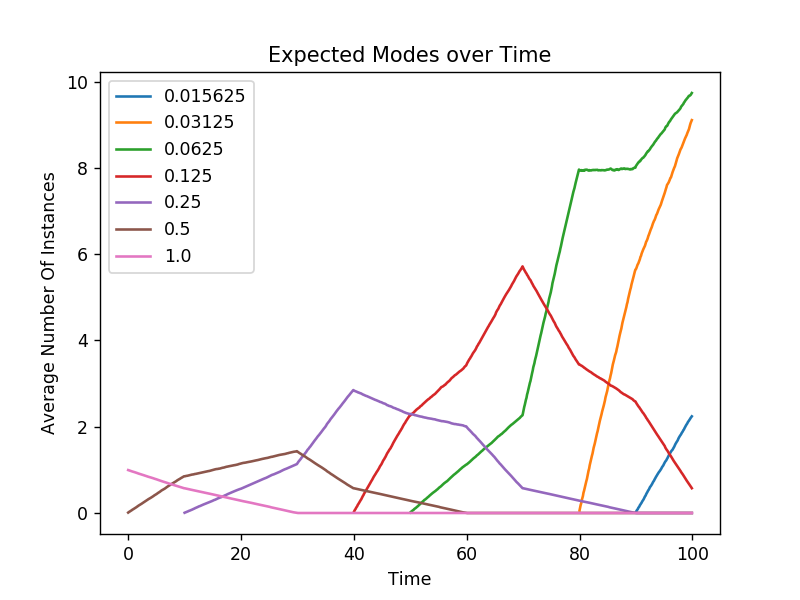

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]


In [104]:
plt.figure()
# fig, ax = plt.subplots(len(list(avg_modes.keys())),1,sharex=True)
x = [i*dt for i in range(duration)]
# print(avg_modes[1])
plotModeData(avg_modes, x, dt, duration, fig, ax)

# print(x.index(3), x.index(7))
# display the slopes by segment
slope_divisions = [(0,10), (10,20), (20,30), (30,40), (40,50),
                   (50,60), (60,70), (70,80), (80,90)#, (90,100),
#                    (100,110), (110,120), (120,130), (130,140), (140,150),
#                    (150,159)
                  ]
slopes, slopes_matrix = getSlopesOfModes(avg_modes, x, slope_divisions)
# for key in slopes:
#     print('mode type:',1/key, end =' ')
#     for val in slopes[key]:
#         print('{:.3f}\t'.format(val), end=' ')
#     print()
        #, slopes[key][1], slopes[key][2], slopes[key][3], slopes[key][4], slopes[key][5]))
np.set_printoptions(precision=4)

# print(slopes_matrix)
# print('summed for each time segment',np.sum(slopes_matrix, axis=0))
non_zero_indices = (slopes_matrix!=0).argmax(axis=0)
non_zero_indices = [i + slopes_matrix.shape[1]*non_zero_indices[i] for i in range(len(non_zero_indices))]

base_slope = np.take(slopes_matrix, non_zero_indices)
# print(np.divide(slopes_matrix, abs(base_slope)))

In [24]:
np.max(avg_modes[.25])

2.8514

<IPython.core.display.Javascript object>


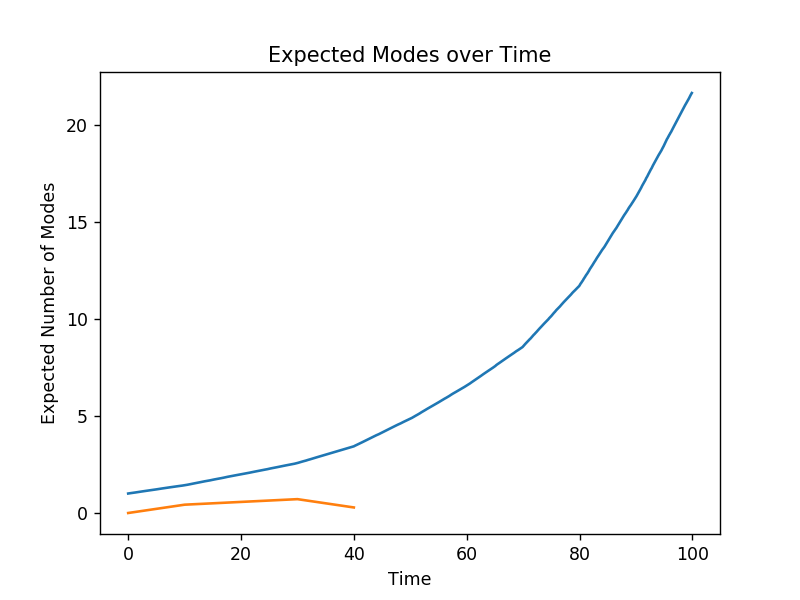

ValueError: 100 is not in list

In [59]:
slope_divisions = [(0,10), (10,20), (20,30), (30,40), (40,50),
                   (50,60), (60,70), (70,80), (80,90), (90,100),
                   (100,110), (110,120), (120,130), (130,140), (140,150),
                   (150,159)
                  ]
plt.figure()
expected_modes = plotNumberOfModes(avg_modes, x, dt, duration)
slopes_of_expected = getSlopesOfMode(expected_modes, x, slope_divisions)
np.set_printoptions(precision=4)
print(np.array(slopes_of_expected))
for slope in slopes_of_expected:
    print('{:.2f}'.format(slope/slopes_of_expected[0]), end=' ')

In [21]:
## Next case scenario where there are two types of intersection
dist_e = 100
layout = (3,3)
dt = .1
duration = 500
v0 = 10
iterations = 10000
avg_modes_3x3 = getAvgModeData(dist_e, layout, dt, duration, v0, iterations)

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


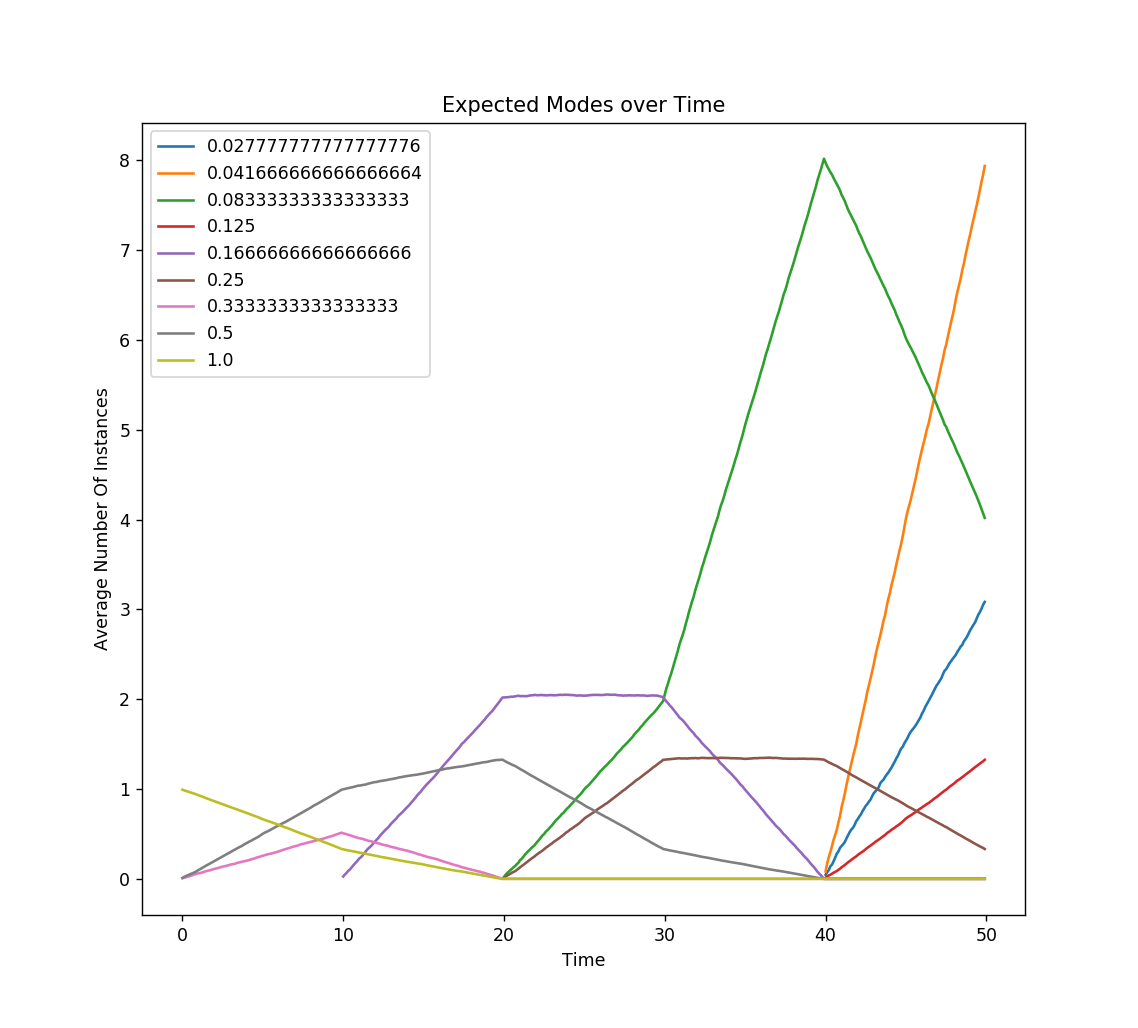

[0.027777777777777776, 0.041666666666666664, 0.08333333333333333, 0.125, 0.16666666666666666, 0.25, 0.3333333333333333, 0.5, 1.0]
slope matrix form
[[-6.6400e-02 -3.3475e-02  0.0000e+00  0.0000e+00]
 [ 9.8850e-02  3.3575e-02 -9.9217e-02 -3.2460e-02]
 [ 5.0925e-02 -4.9050e-02  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  1.3300e-01 -1.7000e-03]
 [ 0.0000e+00  1.9823e-01 -4.5000e-04 -1.9854e-01]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  1.9720e-01  5.9694e-01]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]]
summed for each time segment [0.0834 0.1493 0.2305 0.3642]
slopes proportional to base slope
[[-1.0000e+00 -1.0000e+00  0.0000e+00  0.0000e+00]
 [ 1.4887e+00  1.0030e+00 -1.0000e+00 -1.0000e+00]
 [ 7.6694e-01 -1.4653e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  1.3405e+00 -5.2372e-02]
 [ 0.0000e+00  5.9216e+00 -4.5355e-03 -6.1165e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.000

In [35]:
plt.figure()
np.set_printoptions(precision=4)
x = [i*dt for i in range(duration)]

# fig, ax = plt.subplots(len(list(avg_modes_3x3.keys())),1,sharex=True)
# plotModeData(avg_modes_3x3, x, dt, duration)
plotModeData(avg_modes_3x3, x, dt, duration, fig, ax)

slope_divisions = [(3,7), (12,16), (22,28), (33,38)]#, (42,47)]#,(53,58)]
slopes, slopes_matrix = getSlopesOfModes(avg_modes_3x3, x, slope_divisions)
# for key in slopes:
#     print(1/key,'{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}'.format(slopes[key][0], slopes[key][1], slopes[key][2], slopes[key][3], slopes[key][4], slopes[key][5]))
print('slope matrix form')
print(slopes_matrix)
print('summed for each time segment',np.sum(slopes_matrix, axis=0))
non_zero_indices = (slopes_matrix!=0).argmax(axis=0)
non_zero_indices = [i + slopes_matrix.shape[1]*non_zero_indices[i] for i in range(len(non_zero_indices))]

base_slope = np.take(slopes_matrix, non_zero_indices)
print('slopes proportional to base slope')
print(np.divide(slopes_matrix, abs(base_slope)))

In [109]:
probability_of_split = (4*3*vel)/(2*12*dist_e)
print(probability_of_split)

probability_of_split = (1*4*vel)/(2*12*dist_e)
print(probability_of_split)

print(1-3/(70)*23)

0.05
0.016666666666666666
0.014285714285714235


In [ ]:
### plt.figure()
expected_modes = plotNumberOfModes(avg_modes_3x3, x, dt, duration)
slopes_of_expected = getSlopesOfMode(expected_modes, x, slope_divisions)
np.set_printoptions(precision=4)
print(np.array(slopes_of_expected))
for slope in slopes_of_expected:
    print('{:.2f}'.format(slope/slopes_of_expected[0]), end=' ')

<IPython.core.display.Javascript object>


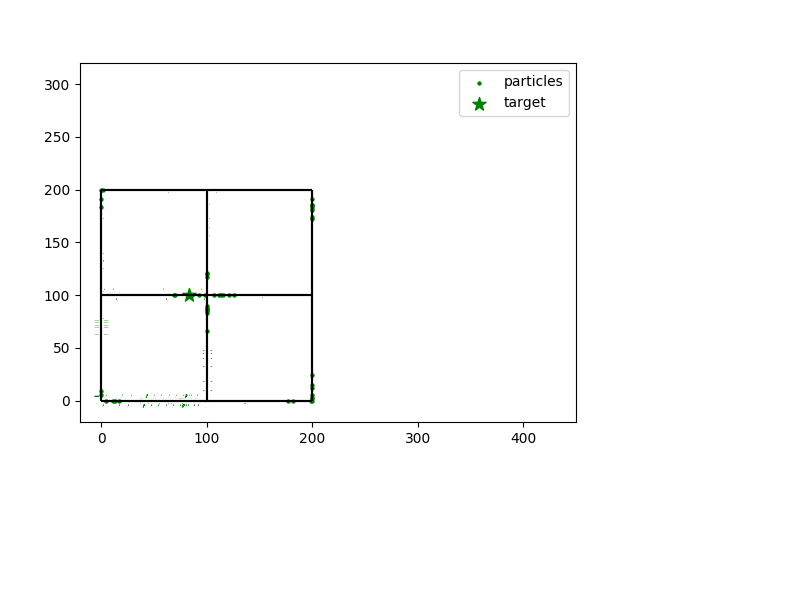

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
4
2
4
2
3
2
5
2
3
2
3
2
3
2
4
3
2
4
3
4
5
4
6
5
6
8
9
10
7
9
11
9
10
8
10
11
9
8
9
8
9
6
8
9
8
9
10
11
9
11
10
11
10
9
10
11
7
10
11
8
9
8
11
9
7
8
7
5
4
6
5
6
7
6
5
6
7
5
8
11
10
7
10
9
8
11
9
10
11
10
9
11
12
11
10
12
10
13
9
13
14
11
10
12
10
12
11
12
10
12
11
10
11
12
10
9
8
9
10
13
11
13
12
13
12
13
12
13
15
13
14
13
12
14
11
9
7
9
6
7
6
7
6
5
6
8
7
8
9
11
14
13
11
12
11
12
14
15
14
15
14
15
14
13
12
13
12
13
12
11
10
11
10
9
11
12
13
11
10
11
12
11
9
11
13
10
11
10
11
10
8
11
10
11
7
6
7
8
6
7
6
8
6
8
9
7
6
8
7
9
8
7
6
5
6
5


KeyboardInterrupt: 

In [151]:
dist_e = 100
nodes, edges = createGridLayout(3,3,dist_e, dist_e)
r = Roadmap(nodes, edges)

N = 50
dt = .1
v0 = 10
Va = 30
sigma_vel = 5
P_fa = .02
P_miss = .05
pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':v0, 'sigma':sigma_vel, 'P_fa':P_fa, 'P_miss':P_miss}
rbpf = RB_PF(r, 10, 1, pf_args)
targets = [Particle(r, v0=v0, dt=dt, sigma=0.1)]
R = 5*np.eye(2)
T_end = 100
agent = AgentSimple((dist_e/2, 0), 100, 50, Va, 30, r, dt=dt)

sim(rbpf, targets, agent, R, dt, T_end)

In [ ]:

R = 5*np.eye(2)
H = []

target1 = Particle(r, v0=0, dt=dt, e0=((0,0),(dist_e,0)), x0=.4, sigma=2)
target2 = Particle(r, v0=0, dt=dt, sigma=2)
targets = [target1]#, target2]
rbpf = RB_PF(r, 10, len(targets), pf_args)

Va = 30
agent = AgentSimple((dist_e/2, 0), 100, 50, Va, 30, r, dt=dt)
# agent = AgentRandom((100, 60), 100, 50, 40, 30, r, dt=dt)

H_current, variances = sim(rbpf, targets, agent, R, dt, T_end)
H += [H_current]

### mode prediction

<IPython.core.display.Javascript object>


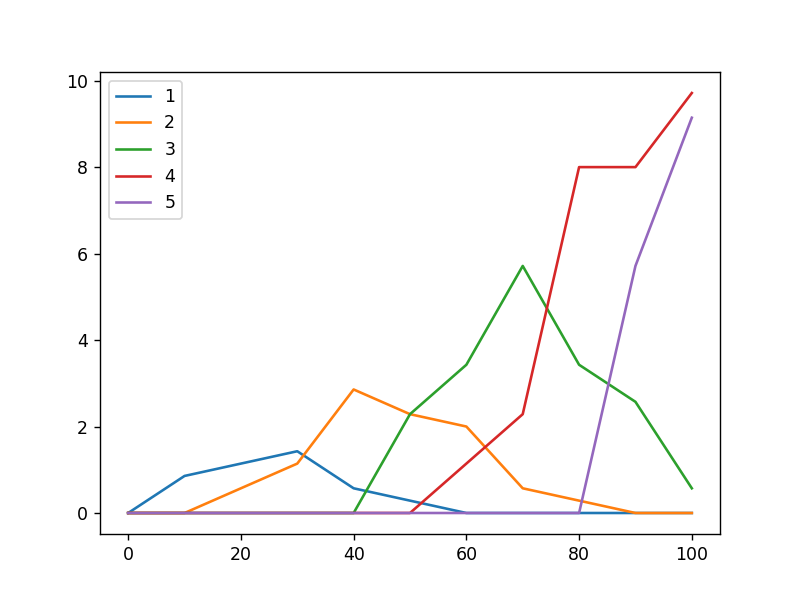

In [121]:
def get_time(t, ts, offset, initial_range):
    time = t - (ts + offset)
    time[np.where(time<0)] = 0
    time[np.where(time>initial_range)] = initial_range
    return time
def get_prob_of_mode_type(prob, initial_range, ts, options, base, t, level, desired_level):
    z = np.zeros((t.shape[0]))
    o = np.zeros((t.shape[0]))
    p = z
    num_options = len(options)
    next_prob = 1./num_options
    if level == desired_level:
        p = prob*get_time(t, ts, 0, initial_range)
        for idx in range(num_options):
            offset = base[options[idx]]['offset']
            p = p - prob*next_prob*get_time(t, ts, offset, initial_range)
        p = 2**level * p
    else:
        first_death = t[-1]+1
        for idx in range(num_options):
            if level < desired_level:
                offset = base[options[idx]]['offset']
                next_options = base[options[idx]]['options']
                p = p + prob*get_prob_of_mode_type(next_prob, initial_range, ts+offset, next_options, base, t, level+1, desired_level)

    return p
    
    
t = np.array([i for i in range(101)])

base = {
    0: {'offset': 10,
       'options': [1,1]},
    1: {'offset': 30,
       'options': [0,1]}
}
base_key = [0,1]
base_value = [10,30]
base_options_next = [[1,1],[0,1]]
plt.figure()
for desired_level in range(1,6):
    data = (1/7)*(1/10)*get_prob_of_mode_type(1, 10, 0, [1,1],base, t, 1, desired_level)
    data = data + (6/7)*(1/30)*get_prob_of_mode_type(1, 30, 0, [0, 1], base, t, 1, desired_level);
    plt.plot(t,data, label=desired_level)
plt.legend()